# TVD schémata

## Hartenovo lemma

Mějme schéma (i nelineární) ve tvaru
$$
u_i^{n+1} = u_i^n - C_{i-1/2}^n (u_i^n-u_{i-1}^n) + D_{i+1/2}^n (u_{i+1}^n-u_i^n).
$$
Nechť
\begin{align*}
C_{i-1/2}^n &\ge 0, \\
D_{i+1/2}^n &\ge 0, \\
C_{i-1/2}^n + D_{i-1/2}^n &\le 1.
\end{align*}
Potom má schéma TVD vlastnost.

## Schéma s omezovačem toku

Numerický tok se zapíše jako
$$
    f^{TVD}_{i+1/2} = f^{lo}_{i+1/2} + \phi_{i+1/2} (f^{hi}_{i+1/2} - f^{lo}_{i+1/2})
$$
kde
* $f^{lo}$ je tok odpovídající monotónnímu schématu (např. upwind), 
* $f^{hi}$ je tok odpovídající schématu vyššího řádu přesnosti (např. Lax-Wendroff),
* $\phi \in \langle 0, 1\rangle$ je tzv. *limiter* (omezovač).

### Swebyho diagram
Kombinací L-W a protiproudového schématu dostaneme (vynechávám horní index $n$)
\begin{multline}
  f_{i+1/2} = 
  a u_i + \phi_{i+1/2} \left( \frac{a}{2}(u_{i+1}+u_i) - \frac{\Delta t a^2}{2\Delta x}(u_{i+1}-u_i) - a u_i\right) = \\
  a u_i + \phi_{i+1/2} \left( \frac{a}{2} - \frac{\Delta t a^2}{2\Delta x}\right) (u_{i+1}-u_i) = 
  a u_i + \phi_{i+1/2} a \beta (u_{i+1}-u_i),
\end{multline}
kde $\beta=\frac{1}{2} - \frac{\Delta t a}{2\Delta x}$ a tedy $0 \le \beta \le \frac{1}{2}$.

Celé schéma je tedy
$$
    u_i^{n+1} = u_i - \frac{\Delta t a}{\Delta x} \left[ (u_i-u_{i-1}) + \beta\left(\phi_{i+1/2} (u_{i+1}-u_i) - \phi_{i-1/2}(u_i-u_{i-1})\right)\right].
$$

Označme $r_{i+1/2} = (u_i-u_{i-1}) / (u_{i+1} - u_i)$ a předpokládejme, že $\phi$ je funkcí $r$. Potom
$$
    u_i^{n+1} = u_i - \frac{\Delta t a}{\Delta x} \left[ 1 + \beta\left(\phi(r_{i+1/2})/r_{i+1/2} - \phi(r_{i-1/2})\right)\right](u_i-u_{i-1}).
$$

Porovnáním s Hartenovým lemmatem dostaneme $D_{i+1/2}=0$ a 
$$
    C_{i-1/2} = \frac{\Delta t a}{\Delta x} \left[ 1 + \beta\left(\phi(r_{i+1/2})/r_{i+1/2} - \phi(r_{i-1/2})\right)\right]
$$
a tedy
$$ 0 \le C_{i-1/2} \le 1$$.

Postačující podmínkou je tedy např. splnění:
* $\Delta t \le \frac{\Delta x}{2a}$,
* $\phi(r) = 0$ pro $r\le 0$, 
* $0 \le \phi(r) \le 2$
* $0 \le \phi(r)/r \le 2$

### Příklad: TVD schéma pro lineární rovnici advekce

In [1]:
using PyPlot

In [2]:
a = 1;

# Delka intervalu a pocet bunek
L = 1;
n = 100;

dx = L / n;
x = linspace(dx/2, L-dx/2, n); 

Tend = 0.25;

In [3]:
function initial_condition(x)
    u = similar(x)
    for i in eachindex(x)
        if 0.25<x[i] && x[i]<0.5 
            u[i] = 1-cos(2π*(4*x[i]-1))
        else
            u[i] = 0.0
        end
    end
    return u
end;

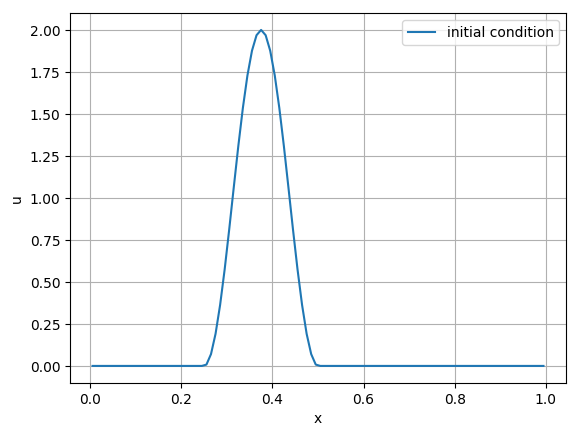

In [4]:
u0 = initial_condition(x);
plot(x, u0, label="initial condition"); xlabel("x"); ylabel("u"); grid(true); legend(loc="upper right");

In [5]:
uex = initial_condition(x-a*Tend);

In [6]:
u = copy(u0)

dt = 0.5*dx

for iter = 1:(Tend/dt)
    f = zeros(n+1)
    
    for i=3:n-1
        flo = a * u[i-1]
        f[i] = flo
    end
    
    for i=1:n
        u[i] = u[i] - dt/dx * (f[i+1] - f[i])
    end
end

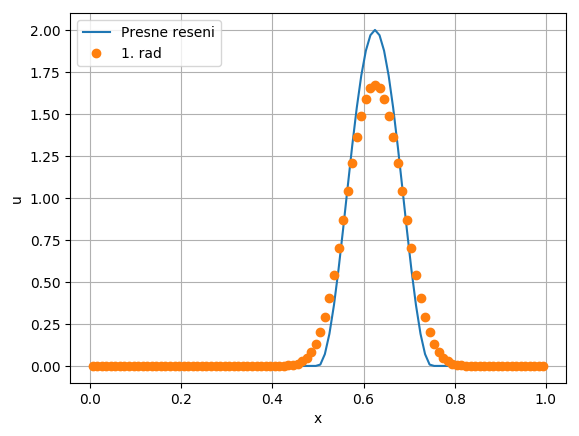

In [7]:
ulo = copy(u);

plot(x, uex, label="Presne reseni");
plot(x, ulo, label="1. rad", "o");
xlabel("x"); ylabel("u"); grid(true); legend(loc="upper left");

In [8]:
u = copy(u0)

dt = 0.5*dx

for iter = 1:(Tend/dt)
    f = zeros(n+1)
    
    for i=3:n-1
        fhi = a*(u[i-1]+u[i])/2 - a^2/2*dt/dx*(u[i]-u[i-1])
        f[i] = fhi
    end
    
    for i=1:n
        u[i] = u[i] - dt/dx * (f[i+1] - f[i])
    end    
end

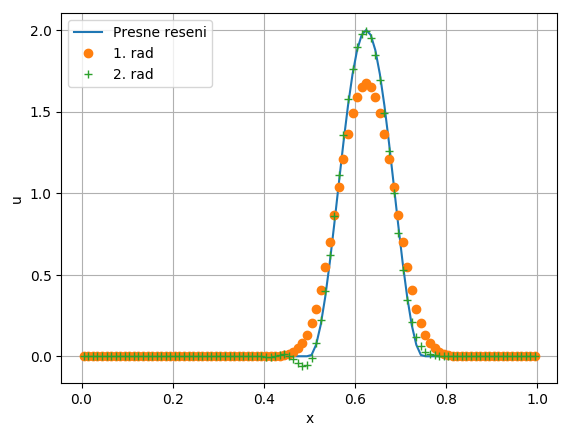

In [9]:
uhi = copy(u);

plot(x, uex, label="Presne reseni");
plot(x, ulo, label="1. rad", "o");
plot(x, uhi, label="2. rad", "+");
xlabel("x"); ylabel("u"); grid(true); legend(loc="upper left");

In [18]:
u = copy(u0)

dt = 0.5*dx

for iter = 1:(Tend/dt)
    f = zeros(n+1)
    
    for i=3:n-1
        flo = a * u[i-1]
        fhi = a*(u[i-1]+u[i])/2 - a^2/2*dt/dx*(u[i]-u[i-1])
 
        if (u[i]-u[i-1])*(u[i+1]-u[i]) <= 0 
           ϕ = 0
        else
          r = (u[i-1]-u[i-2]) / (u[i]-u[i-1]);
          ϕ = min(1, 2*r);
        end
        f[i] = flo + ϕ*(fhi-flo);
    end
    
    for i=1:n
        u[i] = u[i] - dt/dx * (f[i+1] - f[i])
    end
    
end

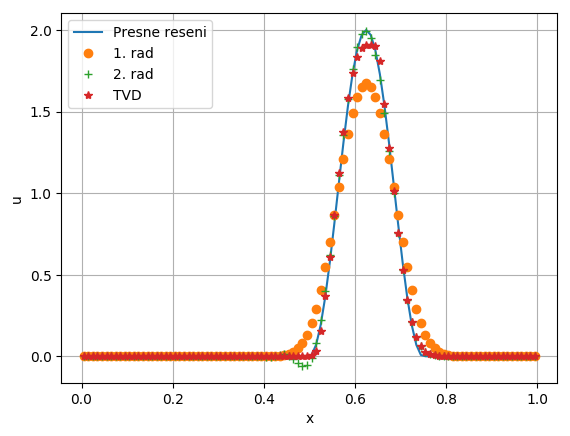

In [19]:
utvd = copy(u);

plot(x, uex, label="Presne reseni");
plot(x, ulo, label="1. rad", "o");
plot(x, uhi, label="2. rad", "+");
plot(x, utvd, label="TVD", "*");
xlabel("x"); ylabel("u"); grid(true); legend(loc="upper left");

## Schéma s rekonstrukcí řešení

In [20]:
upwind(ul,ur) = a*ul;

function minmod(a,b)
    if a*b <= 0
        return 0.0
    else
        if abs(a) < abs(b)
            return a
        else
            return b
        end
    end
end

minmod (generic function with 1 method)

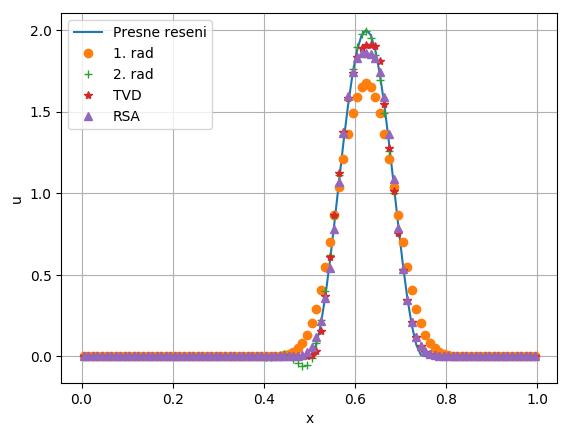

In [22]:
u = copy(u0)

dt = 0.5*dx

function convective_terms(u)
    f = zeros(n+1)
    σ = zeros(n)
    r = zeros(n)
    
    for i=2:n-1
        σₗ = u[i] - u[i-1]
        σᵣ = u[i+1] - u[i]
        
        #σ[i] = minmod(σₗ, σᵣ)
        σ₀ = (σₗ + σᵣ) / 2
        σ[i] = minmod(minmod(2σₗ, σ₀), σᵣ)
    end

    for i=2:n-1
        uₗ = u[i-1] + 0.5*σ[i-1]
        uᵣ = u[i]   - 0.5*σ[i]
        
        f[i] = upwind(uₗ, uᵣ)
    end
    
    for i=1:n
        r[i] = (f[i] - f[i+1]) / dx
    end
    
    return r
end


for iter = 1:(Tend/dt)    
    k1 = convective_terms(u)
    up = u + dt * k1 

    k2 = convective_terms(up)
    u = (u + up + dt*k2) / 2
end

urec = copy(u);

plot(x, uex, label="Presne reseni");
plot(x, ulo, label="1. rad", "o");
plot(x, uhi, label="2. rad", "+");
plot(x, utvd, label="TVD", "*");
plot(x, urec, label="RSA", "^");
xlabel("x"); ylabel("u"); grid(true); legend(loc="upper left");